In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

# Load data from the GitHub raw URL
url = "https://raw.githubusercontent.com/btenneson/public_projects/main/nba_logreg2.csv"
data = pd.read_csv(url)

# Load the CSV file from your local directory
# Replace 'your_file.csv' with the actual path to your CSV file
# data = pd.read_csv("G:\\My Drive\\research\\kaggle\\exercises-lswzxogistic-regression-exercise-1\\exercises-logistic-regression-exercise-1\\data\\nba_logreg2.csv")

# Calculate the number of NaNs in the dataset before filling
# nan_counts_before = data.isna().sum().sum()

# Replace NaNs with the mean of the respective columns
data_filled = data.apply(lambda col: col.fillna(col.mean()) if col.dtype in ['float64', 'int64'] else col)

# Calculate the number of NaNs in the dataset after filling
# nan_counts_after = data_filled.isna().sum().sum()

# Calculate the number of replacements made
# replacements_made = nan_counts_before - nan_counts_after

# replacements_made

data = data_filled

# Define the objective function to maximize the absolute correlation
def objective_function(bias, data):
    # Calculate synthetic scores
    synthetic_scores = data.iloc[:, 1:].dot(bias)
    
    # Correlation with the first column
    correlation = np.corrcoef(data.iloc[:, 0], synthetic_scores)[0, 1]
    
    # Minimize the negative absolute correlation
    return -abs(correlation)

# Initial guess for the bias vector (random values, no need to normalize)
n_minus_1 = data.shape[1] - 1  # Assuming data includes the first column
initial_bias = np.random.rand(n_minus_1)

# Minimization process
result = minimize(
    objective_function,
    initial_bias,
    args=(data,),
    method='Powell',
    options={'disp': True}
)

# Check results
if result.success:
    optimized_bias = result.x
    print("Optimized bias vector:", optimized_bias)
    print("Achieved correlation:", -result.fun)  # Negate to show maximized correlation
else:
    print("Optimization failed:", result.message)


Optimization terminated successfully.
         Current function value: -0.449815
         Iterations: 15
         Function evaluations: 2741
Optimized bias vector: [ 5.10345556e-01 -4.76935091e-01 -2.50646119e+00 -5.26577410e+00
  5.64301003e+00  7.12299168e-01  3.91560844e+01 -1.36781486e+01
  3.38991214e-02  7.26342466e+00 -2.43353900e+00  1.47181330e-01
  1.00059793e+00 -9.18853510e+00  7.67893704e+00  2.91053704e+00
  3.22083585e-01  5.53363188e+00 -3.61551415e+00]
Achieved correlation: 0.4498148218314336


In [3]:
len(optimized_bias)

19

Best Threshold: 0.47000000000000003
Best Accuracy: 71.55%
Confusion Matrix:
 [[235 273]
 [108 723]]
F1 Score: 0.7914614121510674
Precision: 0.7259036144578314
Recall: 0.8700361010830325
AUC: 0.7699041568359911


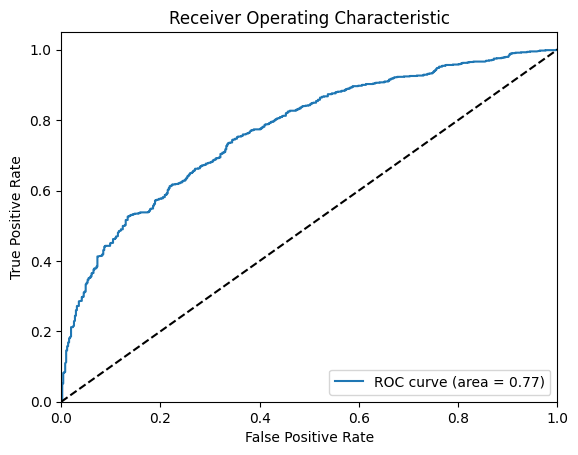

In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame and 'synthetic_scores' column is calculated
if 'synthetic_scores' not in data.columns:
    # Placeholder for your synthetic_scores calculation logic
    synthetic_scores = data.iloc[:, 1:].dot(optimized_bias)
    data['synthetic_scores'] = synthetic_scores

# Initialize the linear regression model
model = LinearRegression()

# The input X needs to be reshaped for fitting with sklearn (single feature)
X = data['synthetic_scores'].values.reshape(-1, 1)  # Predictor - synthetic scores
y = data.iloc[:, 0].values  # Response variable from the first column

# Fit the model
model.fit(X, y)

# Use the model to make predictions
fitted_scores = model.predict(X)

# Function to calculate accuracy for a given threshold
def calculate_accuracy(threshold):
    y_pred = (fitted_scores >= threshold).astype(int)
    return accuracy_score(y, y_pred)

# Test thresholds from 0.0 to 1.0 in small increments
thresholds = np.arange(0.0, 1.01, 0.01)
accuracies = [calculate_accuracy(t) for t in thresholds]

# Find the threshold with the highest accuracy
best_threshold_index = np.argmax(accuracies)
best_threshold = thresholds[best_threshold_index]
best_accuracy = accuracies[best_threshold_index]

# Generate predictions using the best threshold
best_predicted_labels = (fitted_scores >= best_threshold).astype(int)
data['Optimized_Predicted'] = best_predicted_labels

# Print results
print(f"Best Threshold: {best_threshold}")
print(f"Best Accuracy: {best_accuracy * 100:.2f}%")

# Additional metrics
conf_matrix = confusion_matrix(y, best_predicted_labels)
f1 = f1_score(y, best_predicted_labels)
precision = precision_score(y, best_predicted_labels)
recall = recall_score(y, best_predicted_labels)
auc = roc_auc_score(y, fitted_scores)

print("Confusion Matrix:\n", conf_matrix)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("AUC:", auc)

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y, fitted_scores)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [3]:
import lightgbm as lgb

# Assuming 'synthetic_scores' is already calculated and part of your DataFrame
X = data['synthetic_scores'].values.reshape(-1, 1)  # Use synthetic scores as features
y = data.iloc[:, 0].values  # The target variable

# Convert the data into LightGBM dataset format
lgb_train = lgb.Dataset(X, label=y)

# Define LightGBM parameters
params = {
    'objective': 'binary',  # Assuming the target is binary
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# Train the LightGBM model
gbm = lgb.train(params, lgb_train, num_boost_round=100)


[LightGBM] [Info] Number of positive: 831, number of negative: 508
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000200 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 1339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.620612 -> initscore=0.492148
[LightGBM] [Info] Start training from score 0.492148


Best Threshold: 0.48
Best Accuracy: 75.88%
Confusion Matrix:
 [[286 222]
 [101 730]]
F1 Score: 0.8188446438586652
Precision: 0.7668067226890757
Recall: 0.8784596871239471
AUC: 0.8330016960876279


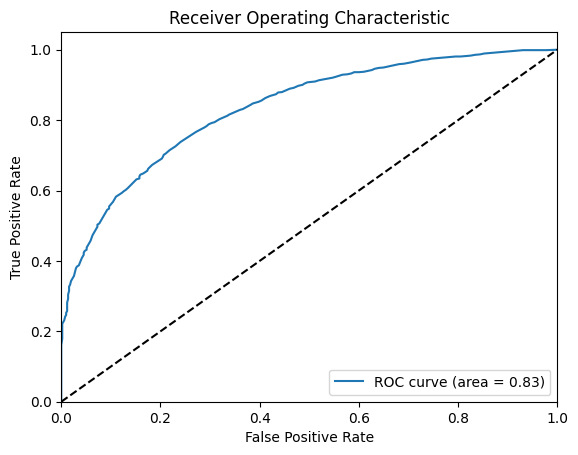

In [4]:
# Make predictions
fitted_scores = gbm.predict(X)

# Function to calculate accuracy for a given threshold
def calculate_accuracy(threshold):
    y_pred = (fitted_scores >= threshold).astype(int)
    return accuracy_score(y, y_pred)

# Test thresholds from 0.0 to 1.0 in small increments
thresholds = np.arange(0.0, 1.01, 0.01)
accuracies = [calculate_accuracy(t) for t in thresholds]

# Find the threshold with the highest accuracy
best_threshold_index = np.argmax(accuracies)
best_threshold = thresholds[best_threshold_index]
best_accuracy = accuracies[best_threshold_index]

# Generate predictions using the best threshold
best_predicted_labels = (fitted_scores >= best_threshold).astype(int)
data['Optimized_Predicted'] = best_predicted_labels

# Print results
print(f"Best Threshold: {best_threshold}")
print(f"Best Accuracy: {best_accuracy * 100:.2f}%")

# Additional metrics
conf_matrix = confusion_matrix(y, best_predicted_labels)
f1 = f1_score(y, best_predicted_labels)
precision = precision_score(y, best_predicted_labels)
recall = recall_score(y, best_predicted_labels)
auc = roc_auc_score(y, fitted_scores)

print("Confusion Matrix:\n", conf_matrix)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("AUC:", auc)

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y, fitted_scores)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
